In [1]:
import pickle

with open('spy5m_labelled_episodes.pkl', 'rb') as f:
    df_original = pickle.load(f)

# PZ algorithm has some look ahead so remove the episode labels, will be uesd only for some kind of analysis afterwards
df = df_original.drop(columns=['episode']) 
# df

In [31]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def gen_chunk_base(df: pd.DataFrame, sample_size: int):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    # Split data into training and validation sets
    X_train, X_val = train_test_split(X, test_size=0.3, random_state=777)

    # Define the range of components to test
    n_components_range = range(1, 2)

    # Lists to store BIC and AIC scores
    bic_scores = []
    aic_scores = []
    gmms = []

    # Fit GMM models for each number of components and calculate BIC and AIC
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=777)
        gmm.fit(X_train)
        gmms.append(gmm)
        bic_scores.append(gmm.bic(X_val))
        aic_scores.append(gmm.aic(X_val))

    # Select the model with the lowest BIC
    optimal_components = n_components_range[np.argmin(bic_scores)]
    print(f"Optimal number of components according to BIC: {optimal_components}")

    gmm = gmms[optimal_components - 1]
    sample = gmm.sample(sample_size)[0]
    sample = scaler.inverse_transform(sample)
    sample = pd.DataFrame(sample, columns=df.columns)
    y = sample['label']
    # enforce a few simple logical rules on the generated sample
    y = y.round().abs()
    X = sample.drop('label', axis=1)
    X['high'] = X[['open', 'close', 'high', 'low']].max(axis=1)
    X['low'] = X[['open', 'close', 'high', 'low']].min(axis=1)

    return X,y



In [ ]:
def gen_chunk(df: pd.DataFrame, sample_size: int, split_by_label: bool = False):
    # While inheriting labels by splitting the df by class and using separate GMMs:
    if split_by_label:
        sample_X_slices = []
        sample_y_slices = []
        for label in df.label.unique():
            df2 = df[df.label == label]
            sample_X_slice, _ = gen_chunk_base(df2, int(sample_size/len(df.label.unique())))
            sample_X_slices.append(sample_X_slice)
            sample_y_slices.append(pd.Series([label] * len(sample_X_slice)) ) # fill with repeated label to inherit from the class split
        X = pd.concat(sample_X_slices, axis=0)
        y = pd.concat(sample_y_slices, axis=0)
    # While Attempting to generate labels:
    else:
        X,y = gen_chunk_base(df, sample_size)
    
    return X,y

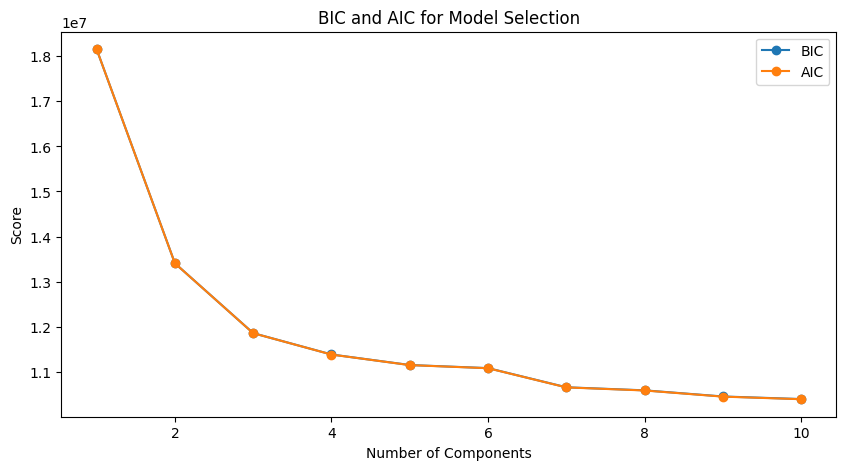

Optimal number of components according to BIC: 10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Generate synthetic data for demonstration (replace with your data)
np.random.seed(42)
# X = np.vstack([np.random.normal(loc, 0.5, (100, 2)) for loc in [(2, 2), (6, 6), (10, 10)]])
X = df.copy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.3, random_state=777)

# Define the range of components to test
n_components_range = range(1, 11)

# Lists to store BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM models for each number of components and calculate BIC and AIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=777)
    gmm.fit(X_train)
    bic_scores.append(gmm.bic(X_val))
    aic_scores.append(gmm.aic(X_val))

# Plot BIC and AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for Model Selection')
plt.legend()
plt.show()

# Select the model with the lowest BIC
optimal_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components according to BIC: {optimal_components}")


In [17]:
pd.DataFrame(gmm.sample(10)[0], columns=df.columns)

,volume,vwap,open,close,high,low,transactions
0,1.693020e+06,121.602224,121.605454,121.672415,121.670716,121.589817,4216.390382
1,8.493875e+03,409.615315,409.603729,409.630157,409.673830,409.529023,37.453504
2,1.996784e+06,179.631183,179.659166,179.779838,179.895710,179.567812,2670.517437
3,-3.187003e+05,169.890138,169.910540,169.901658,169.964709,169.829649,-1282.912515
4,8.056588e+05,186.273026,186.302198,186.227351,186.336461,186.219097,3817.175571
5,1.208474e+06,141.365174,141.326069,141.348571,141.487220,141.266940,5816.163270
6,5.856064e+05,472.065351,471.855478,471.939255,472.214350,471.797247,6380.958481
7,1.038009e+06,339.108548,339.132069,338.842494,339.428841,338.807568,8048.265901
8,5.211013e+05,401.714947,401.886257,401.713896,401.999478,401.541117,4143.782774
9,1.873147e+06,131.089452,130.453157,130.763546,130.593253,130.548369,2513.486168
